<a href="https://colab.research.google.com/github/lenkaakhila/lenkaakhila/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     175777 non-null  float64
 1   created_at                                    175777 non-null  object 
 2   actual_delivery_time                          175777 non-null  object 
 3   store_primary_category                        175777 non-null  int64  
 4   order_protocol                                175777 non-null  float64
 5   total_items                                   175777 non-null  int64  
 6   subtotal                                      175777 non-null  int64  
 7   num_distinct_items                            175777 non-null  int64  
 8   min_item_price                                175777 non-null  int64  
 9   max_item_price                                17

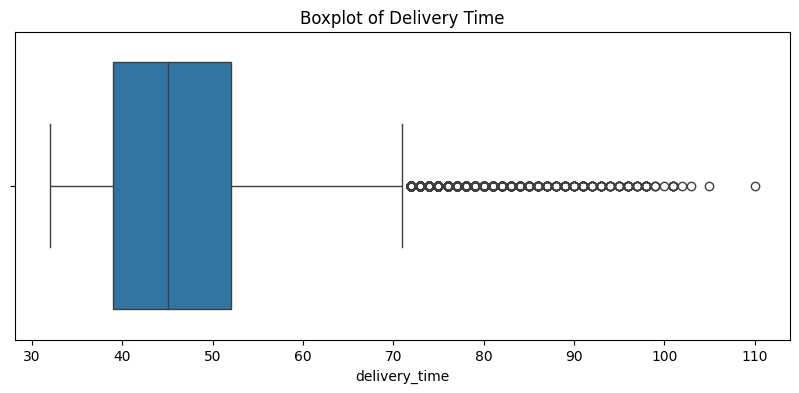

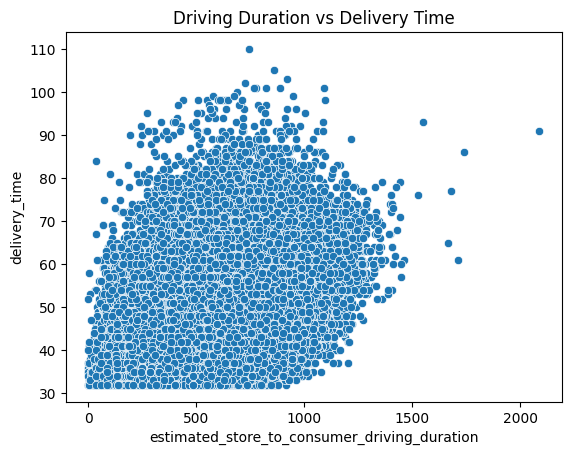

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3495/3495 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 178.1415 - mae: 6.8019 - val_loss: 5.2355 - val_mae: 1.5775
Epoch 2/50
3495/3495 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 4.6413 - mae: 1.4949 - val_loss: 3.2976 - val_mae: 1.2450
Epoch 3/50
3495/3495 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2.8334 - mae: 1.1347 - val_loss: 2.0907 - val_mae: 0.8330
Epoch 4/50
3495/3495 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.8184 - mae: 0.8296 - val_loss: 4.1164 - val_mae: 0.7264
Epoch 5/50
3495/3495 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.1250 - mae: 0.6630 - val_loss: 5.5962 - val_mae: 0.6219
Epoch 6/50
3495/3495 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.0040 - mae: 0.6070 - val_loss: 9.6396 - val_mae: 0.5652


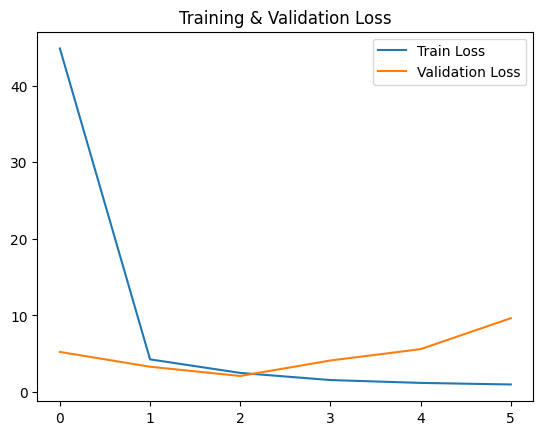

1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE: 1.73
RMSE: 1.32
MAE: 0.84


In [1]:
# Porter Delivery Time Estimation - Regression with Neural Networks

# 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 2. Load and Inspect Data
df = pd.read_csv('/content/data_2 (1).csv')  # Replace with actual path
df.info()
df.head()

# 3. Convert Timestamps to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# 4. Feature Engineering - Delivery Time
df['delivery_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# 5. Extract Time Features
df['order_hour'] = df['created_at'].dt.hour
df['order_day'] = df['created_at'].dt.dayofweek

# 6. Handle Missing Values
df = df.dropna()

# 7. Encode Categorical Columns
df = pd.get_dummies(df, columns=['store_primary_category'], drop_first=True)

# 8. Visualizations
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['delivery_time'])
plt.title('Boxplot of Delivery Time')
plt.show()

sns.scatterplot(x='estimated_store_to_consumer_driving_duration', y='delivery_time', data=df)
plt.title('Driving Duration vs Delivery Time')
plt.show()

# 9. Remove Outliers using Z-score
z = np.abs(stats.zscore(df['delivery_time']))
df = df[(z < 3)]

# 10. Prepare Features and Target
X = df.drop(['created_at', 'actual_delivery_time', 'delivery_time'], axis=1)
y = df['delivery_time']

# 11. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 12. Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 13. Build Neural Network
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # Linear output for regression

# 14. Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 15. Train Model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])


# 16. Plot Losses
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

# 17. Evaluate Model
y_pred = model.predict(X_test_scaled).flatten()
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
